<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#BCS" data-toc-modified-id="BCS-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>BCS</a></span></li><li><span><a href="#Varying-Depth-size" data-toc-modified-id="Varying-Depth-size-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Varying Depth size</a></span></li></ul></div>

# BCS

Using the Paper by [Wu et al.](https://arxiv.org/abs/quant-ph/0108110), we have that:

The BCS hamiltonian is:

$$H_{BCS} = \sum_{m=1}^N \frac{\epsilon_m}{2} ( n_m^F + n_{-m}^F ) + \sum_{m,k=1}^N V^{+}_{ml} c^\dagger_m c^\dagger_{-m} c_{-l}c_l$$

Where $n_{\pm m}^F = c^\dagger_{\pm m} c_{\pm m}$, and the matrix elements $V^+_{ml} = \langle m, -m| V | l, -l \rangle$.

Which is mapped into:

$$H_P = \sum_{m=1}^N \frac{\epsilon_m}{2} \sigma^Z_m + \sum_{r= \pm l} \sum_{l>m=1}^N \frac{V_{ml}^r}{2} ( \sigma^x_m \sigma^x_l + r \sigma^y_m \sigma^y_l )$$

where $\epsilon_m = \epsilon_m + V^+_{mm}$ and $V^-_{ml} = 0$ for the BCS Hamiltonian, thus:

$$H_P = \sum_{m=1}^N \frac{\epsilon_m}{2} \sigma^Z_m +  \sum_{l>m=1}^N \frac{V_{ml}}{2} ( \sigma^x_m \sigma^x_l +  \sigma^y_m \sigma^y_l )$$

$l \ \mathrm{and} \ m$ now denote both state and qubit indices. In this case the qubit state space $H_P = Span \{ |0 \rangle, \sigma^+_m |0 \rangle, \sigma_l^+ \sigma_m^+ |0 \rangle, \dots   \}$ is mapped into a subspace where $n_m^F = n^F_{-m}$. Considering $V_{ml} = V$, we have that:

$$
H_p = \hbar \bigg[ \sum_{m=1}^N \frac{\epsilon_m}{2} \sigma_z^m + \frac{V}{2} \sum_{l>m=1}^N (\sigma_x^m \sigma_x^l + \sigma_y^m \sigma_y^l) \bigg]
$$
[Aqua Operator Flow Reference](https://github.com/dongreenberg/aqua_talks/blob/master/Understanding%20Aqua's%20Operator%20Flow.ipynb)

In [70]:
import sys
sys.path.append('../../')

# Python imports
import numpy as np
import matplotlib.pyplot as plt

# Qiskit
from qiskit import BasicAer
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal

# VOLTA
from VOLTA.VQD import VQD
from VOLTA.utils import classical_solver
from VOLTA.Hamiltonians import BCS_hamiltonian

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
EPSILONS = [3., 3.]
V = -2
hamiltonian = BCS_hamiltonian(EPSILONS, V)
print(hamiltonian)

SummedOp([
  1.5 * ZI,
  1.5 * IZ,
  -1.0 * XX,
  -1.0 * YY
])


In [83]:
eigenvalues, eigenvectors = classical_solver(hamiltonian)
print(f"Eigenvalues: {eigenvalues}")

Eigenvalues: [-3. -2.  2.  3.]


# Varying Depth size

In [16]:
from tqdm import tqdm
from qiskit.aqua import QuantumInstance

# Parameters Variables
n_trials = 20
max_depth = 5

# Auxiliary Variables
solution_dict = {}

# Define Optimizer
optimizer = COBYLA()

# Define Backend
backend = QuantumInstance(backend=BasicAer.get_backend('qasm_simulator'),
                          shots=10000)

for depth in range(1,max_depth):
    # Ansatz with diferent depth
    ansatz = TwoLocal(hamiltonian.num_qubits, ['ry','rz'], 'cx', reps=depth)
    es_1 = []
    es_2 = []
    
    for _ in tqdm(range(n_trials)):

        # Run algorithm
        Algo = VQD(hamiltonian=hamiltonian,
                    ansatz=ansatz,
                    n_excited_states=2,
                    beta=10.,
                    optimizer=optimizer,
                    backend=backend)

        Algo.run(0)      
        vqd_energies = Algo.energies
        es_1.append(vqd_energies[1])
        es_2.append(vqd_energies[2])
    es_1 = np.array(es_1)
    es_2 = np.array(es_2)
    
    # Maybe use a pd.dataframe
    solution_dict[depth] = {'mean':np.mean(es_2 - es_1), 'std':np.std(es_2 - es_1)}

100%|██████████| 20/20 [1:25:46<00:00, 247.97s/it]


In [19]:
mean = []
std = []
for i in range(1,max_depth):
    mean.append(solution_dict[i]['mean'])
    std.append(solution_dict[i]['std'])

In [26]:
solution_dict

{1: {'mean': 2.90006, 'std': 1.9713680550318347},
 2: {'mean': 4.19897, 'std': 0.5724704438658821},
 3: {'mean': 4.048035, 'std': 0.5554115584636317},
 4: {'mean': 4.117395, 'std': 0.4589107380253812}}

In [39]:
import seaborn as sns
sns.set()

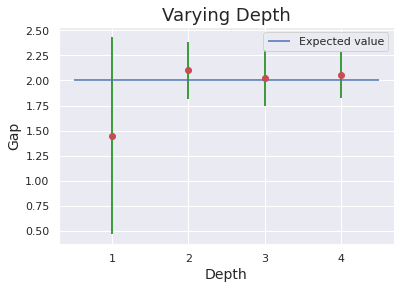

In [49]:
from matplotlib.ticker import MaxNLocator

x_axis = [i for i in range(1,max_depth)]
plt.errorbar(x_axis,
             np.array(mean)/2, 
             yerr=np.array(std)/2,
             fmt='ro', ecolor='green')

plt.hlines(y=2, xmin=0.5, xmax=4.5, 
           label='Expected value',color='b')
plt.title('Varying Depth', size=18)
plt.xlabel('Depth', size= 14)
plt.ylabel('Gap', size=14)
plt.xticks(x_axis)
plt.legend()
plt.show()